In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision.utils import make_grid
import torchvision 
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt

from datetime import datetime

import os

from PIL import Image

from tqdm import tqdm, trange

In [2]:
# finding the dimensions to resize images to

def zerosForName(s):
    if(len(s) == 4):
        return s
    elif(len(s) == 3):
        return "0" + s
    elif(len(s) == 2):
        return "00" + s
    elif(len(s) == 1):
        return "000" + s

data_dir = '../input/brain-tumor-mri-dataset/Training'
classes = os.listdir(data_dir)

minminheight, minminwidth = 69420, 69420

for test_train in ["Testing", "Training"]:
    
    for brain in classes:

        with Image.open("../input/brain-tumor-mri-dataset/"+test_train+"/"+brain+"/"+test_train[0:2]+"-"+brain[0:2]+"Tr_0000.jpg") as img:
            minwidth, minheight = img.size

        for i in range(1, 10):
            with Image.open("../input/brain-tumor-mri-dataset/"+test_train+"/"+brain+"/"+test_train[0:2]+"-"+brain[0:2]+"Tr_"+zerosForName(str(i))+".jpg") as img:
                width, height = img.size
                if(height < minheight):
                    minheight = height
                if(width < minwidth):
                    minwidth = width

        for i in range(10, 69420): # basically works as while(True)
            try:
                with Image.open("../input/brain-tumor-mri-dataset/"+test_train+"/"+brain+"/"+test_train[0:2]+"-"+brain[0:2]+"_"+zerosForName(str(i))+".jpg") as img:
                    width, height = img.size
                    if(height < minheight):
                        minheight = height
                    if(width < minwidth):
                        minwidth = width
            except:
                pass
        
        if(minheight < minminheight):
            minminheight = minheight
        if(minwidth < minminwidth):
            minminwidth = minwidth

print("Minimum height:", minminheight, "\nMinimum width:", minminwidth)

Minimum height: 168 
Minimum width: 150


In [3]:
K = len(classes)
print("Classes: ", classes)
print("Number of classes:", K)

Classes:  ['pituitary', 'notumor', 'meningioma', 'glioma']
Number of classes: 4


In [4]:
in_channels = 3 # R G B
kernel_size = 3 # the code currently only works for kernel_size = 3
stride = 1 # the code currently only works for stride = 1

model = nn.Sequential(
    nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=kernel_size, stride=stride),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size, stride=stride),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_size, stride=stride),
    nn.Flatten(),
    nn.Dropout(p=0.2),
    nn.Linear(128 * (minminwidth - ((kernel_size) // stride - 1) * 3) * (minminheight - ((kernel_size) // stride - 1) * 3), 128), # i think i have incorrectly incorporated stride and kernel_size into the formula
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(32, K)
)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=2985984, out_features=128, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.2, inplace=False)
  (10): Linear(in_features=128, out_features=32, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.2, inplace=False)
  (13): Linear(in_features=32, out_features=4, bias=True)
)

In [6]:
train_transform = transforms.Compose([
        transforms.Resize((minminwidth, minminheight)),
        transforms.ToTensor(),
])

In [7]:
dataset = ImageFolder("../input/brain-tumor-mri-dataset/Training", transform=train_transform)
testset = ImageFolder("../input/brain-tumor-mri-dataset/Testing", transform=train_transform)

In [8]:
batch_size = 16

train_loader = DataLoader(
    dataset=dataset, 
    batch_size=batch_size, 
    shuffle=True
)

test_loader = DataLoader(
    dataset=testset, 
    batch_size=batch_size, 
    shuffle=False
)

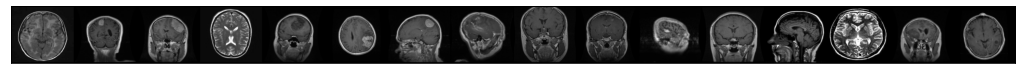

In [9]:
# arranging sample data

for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [11]:
epochs = 8

t_initial = datetime.now()

def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        print()
        print()
        print(f'Epoch {it+1}/{epochs}:')
        print()
        
        model.train()
        
        t0 = datetime.now()
        
        train_loss = []
        
        print("Training:")
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        print()
        
        train_loss = np.mean(train_loss)

        model.eval()
        
        test_loss = []
        
        print("Testing:")
        for inputs, targets in tqdm(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        print()
        
        test_loss = np.mean(test_loss)

        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')

    return train_losses, test_losses

print("Beginning training")
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=epochs)

print()
print()
print("Total duration:", datetime.now() - t_initial)

Beginning training


Epoch 1/8:

Training:


100%|██████████| 357/357 [01:21<00:00,  4.37it/s]



Testing:


100%|██████████| 82/82 [00:08<00:00,  9.40it/s]



Epoch 1/8, Train Loss: 1.0272, Test Loss: 0.7314, Duration: 0:01:30.407475


Epoch 2/8:

Training:


100%|██████████| 357/357 [01:16<00:00,  4.67it/s]



Testing:


100%|██████████| 82/82 [00:08<00:00,  9.29it/s]



Epoch 2/8, Train Loss: 0.5709, Test Loss: 0.4193, Duration: 0:01:25.340506


Epoch 3/8:

Training:


100%|██████████| 357/357 [01:16<00:00,  4.70it/s]



Testing:


100%|██████████| 82/82 [00:08<00:00,  9.25it/s]



Epoch 3/8, Train Loss: 0.3801, Test Loss: 0.3617, Duration: 0:01:24.886695


Epoch 4/8:

Training:


100%|██████████| 357/357 [01:16<00:00,  4.66it/s]



Testing:


100%|██████████| 82/82 [00:08<00:00,  9.15it/s]



Epoch 4/8, Train Loss: 0.3435, Test Loss: 0.3032, Duration: 0:01:25.527711


Epoch 5/8:

Training:


100%|██████████| 357/357 [01:16<00:00,  4.67it/s]



Testing:


100%|██████████| 82/82 [00:09<00:00,  9.02it/s]



Epoch 5/8, Train Loss: 0.2407, Test Loss: 0.4108, Duration: 0:01:25.577109


Epoch 6/8:

Training:


100%|██████████| 357/357 [01:16<00:00,  4.67it/s]



Testing:


100%|██████████| 82/82 [00:08<00:00,  9.13it/s]



Epoch 6/8, Train Loss: 0.2165, Test Loss: 0.2594, Duration: 0:01:25.397492


Epoch 7/8:

Training:


100%|██████████| 357/357 [01:16<00:00,  4.68it/s]



Testing:


100%|██████████| 82/82 [00:08<00:00,  9.22it/s]


Epoch 8/8, Train Loss: 0.1416, Test Loss: 0.2795, Duration: 0:01:25.162625


Total duration: 0:11:27.702419


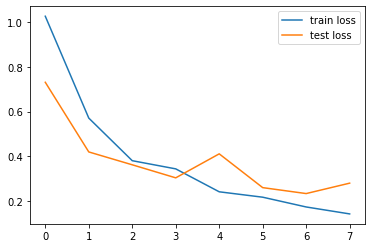

In [12]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [13]:
model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Training accuracy: {train_acc:.4f}%, \nTesting accuracy: {test_acc:.4f}%")

Training accuracy: 0.9811%, 
Testing accuracy: 0.9207%
